notebook 2
- dodać zmienną celu czyli nastepny tydzień itp jako funkcja
- wybór jakie zmienne mniej więcej użyć
- najwyżej mocny split zrobić żeby cały 2023 zostawić


### Importy

In [12]:
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *

In [13]:
prefix = "NFLX"

In [14]:
df_with_weekends = pd.read_csv("csv/"+prefix+'_with_weekends.csv')
df_without_weekends = pd.read_csv("csv/"+prefix+'_without_weekends.csv')

### Analiza

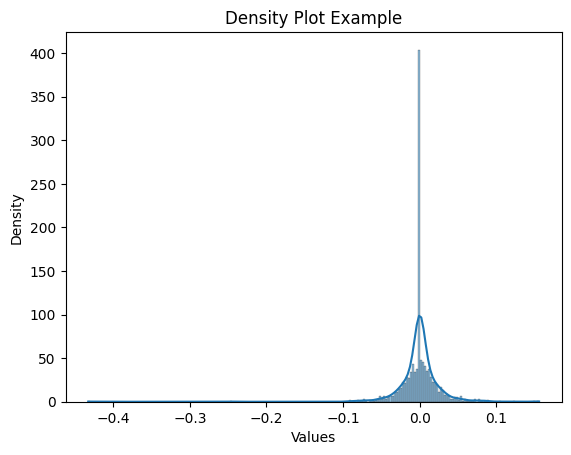

In [24]:
plot_density(df_with_weekends['log_return_1'], title='Density Plot Example', xlabel='Values')

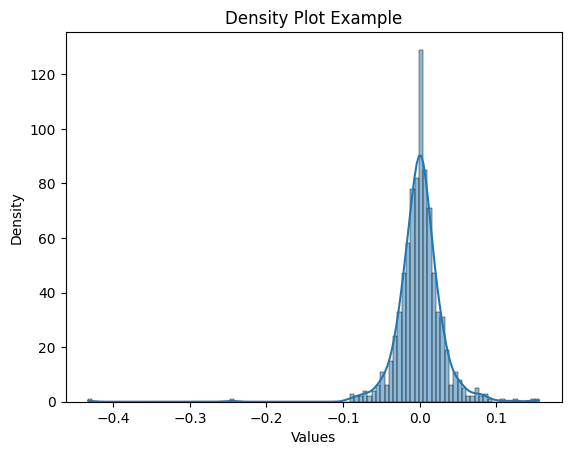

In [25]:
plot_density(df_without_weekends['log_return_1'], title='Density Plot Example', xlabel='Values')

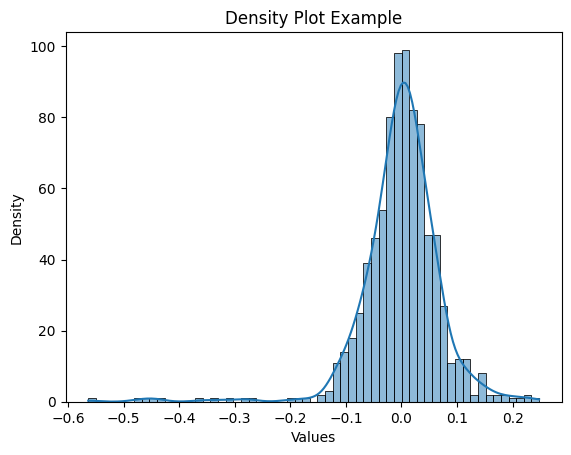

In [26]:
plot_density(df_without_weekends['log_return_5'], title='Density Plot Example', xlabel='Values')

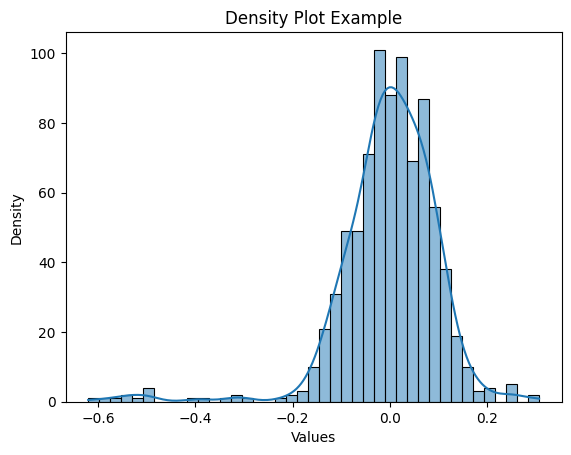

In [27]:
plot_density(df_without_weekends['log_return_10'], title='Density Plot Example', xlabel='Values')

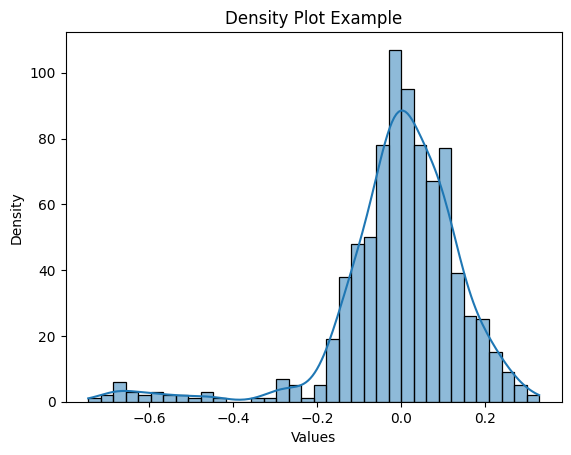

In [28]:
plot_density(df_without_weekends['log_return_20'], title='Density Plot Example', xlabel='Values')

### TRAIN-VAL-TEST Normalizacja

In [15]:
df_without_weekends.drop(columns=['NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close', 'Unnamed: 0', '^GSPC_Close','vwap_14'], inplace=True) 

In [16]:
df_without_weekends['target_1'] = df_without_weekends['log_return_1'].shift(-1)
df_without_weekends['target_5'] = df_without_weekends['log_return_5'].shift(-5)
df_without_weekends['target_10'] = df_without_weekends['log_return_10'].shift(-10)
df_without_weekends['target_20'] = df_without_weekends['log_return_20'].shift(-20)

In [17]:
train_set, val_set, test_set = split_data(df_without_weekends, 'Date', '2023-07-01', '2023-09-01', start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(651, 50)
(44, 50)
(61, 50)


In [18]:
cols_min_max = ['^GSPC_Volume', 'NFLX_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

train_set, scaler_min_max = min_max_scale(train_set,'Date', cols_min_max, train_data=True, scaler=None)
val_set = min_max_scale(val_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)
test_set = min_max_scale(test_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

In [19]:
train_set.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', 'EURUSD=X_Close',
       'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
       'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
       'log_return_1', 'log_return_5', 'log_return_10', 'log_return_20',
       'log_return_gspc_1', 'log_return_gspc_5', 'log_return_gspc_10',
       'log_return_gspc_20', 'target_1', 'target_5', 'target_10', 'target_20',
       'minmax_^GSPC_Volume', 'minmax_NFLX_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       

In [20]:
train_set.to_csv("csv/"+prefix+"/train_set_full.csv")
test_set.to_csv("csv"+prefix+"test_set_full.csv")
val_set.to_csv("csv/"+prefix+"/val_set_full.csv")

### ZMIENNE

In [21]:
train_set.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', 'EURUSD=X_Close',
       'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
       'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
       'log_return_1', 'log_return_5', 'log_return_10', 'log_return_20',
       'log_return_gspc_1', 'log_return_gspc_5', 'log_return_gspc_10',
       'log_return_gspc_20', 'target_1', 'target_5', 'target_10', 'target_20',
       'minmax_^GSPC_Volume', 'minmax_NFLX_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       

In [22]:
def window_dataset(df, target_column, window_size):
    X = []
    y = []

    # Iterate over the dataset
    for i in range(len(df) - window_size):
        # Extract the window of data
        window = df[i:i+window_size]

        # Extract the features (X) and target (y)
        X.append(window.drop(columns=[target_column]).values)
        y.append(window[target_column].values)

    return np.array(X), np.array(y)

train_set.set_index('Date', inplace=True)
X,y = window_dataset(train_set.drop(columns=['log_return_5', 'log_return_10', 'log_return_20',
                        'log_return_gspc_5', 'log_return_gspc_10','log_return_gspc_20',
                        'target_5', 'target_10', 'target_20']), 'target_1', 5)


In [ ]:
tf.keras.backend.clear_session()

# Set the learning rate
learning_rate = 8e-4
#10e-7
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

history = model.fit(X_train, y_train, epochs=300)

In [62]:
def calculate_lagged_correlation(col1, col2, df, lag=14):
    """
    Calculate time-series correlation between two columns across a specified time lag.

    Parameters:
    - col1 (str): Name of the first column.
    - col2 (str): Name of the second column.
    - df (pd.DataFrame): The input DataFrame.
    - lag (int): Maximum lag for which to calculate correlation.

    Returns:
    - pd.Series: Series containing correlations for each lag.
    """
    # Create an empty DataFrame to store correlations
    correlations = pd.DataFrame(columns=['Lag', 'Correlation'])

    # Iterate over lags and calculate correlation for each lag shift
    for i in range(1, lag + 1):
        shifted_col2 = df[col2].shift(i)
        correlation = df[col1].corr(shifted_col2)

        # Save lag and correlation in the DataFrame

        correlations = pd.concat([correlations, pd.DataFrame({'Lag': [i], 'Correlation': [correlation]})], axis=0)
         

    return correlations

C:\Users\HP\AppData\Local\Temp\ipykernel_3292\3658957009.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlations = pd.concat([correlations, pd.DataFrame({'Lag': [i], 'Correlation': [correlation]})], axis=0)
C:\Users\HP\AppData\Local\Temp\ipykernel_3292\3658957009.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlations = pd.concat([correlations, pd.DataFrame({'Lag': [i], 'Correlation': [correlation]})], axis=0)
C:\Users\HP\AppData\Local\Temp\ipykernel_3292\3658957009.py:24: Fu

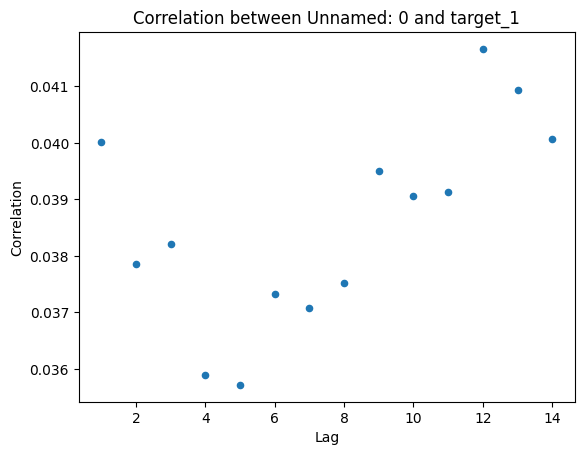

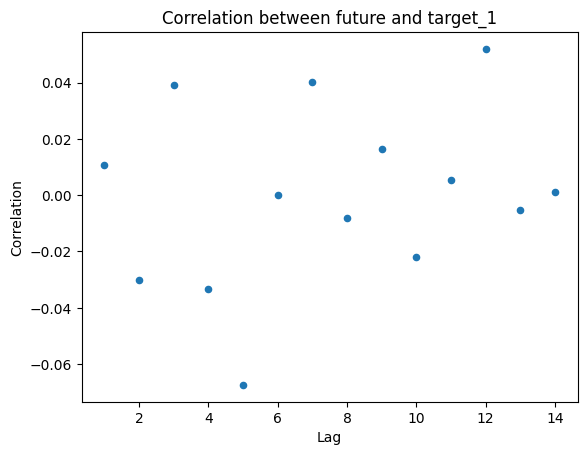

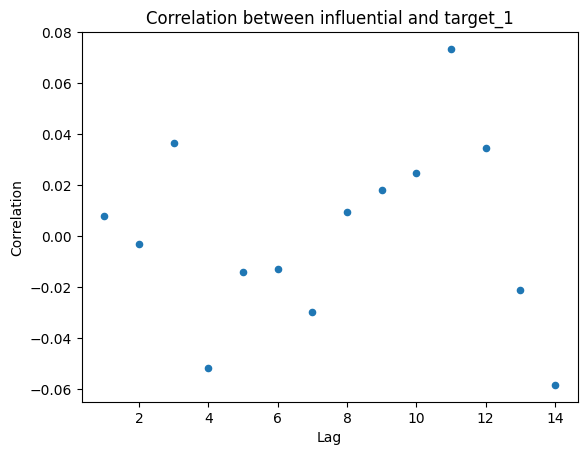

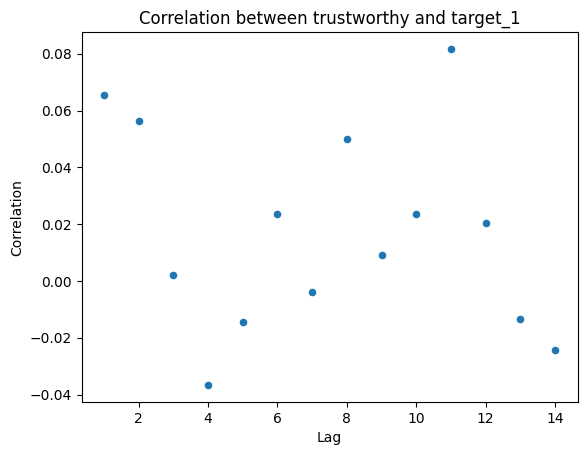

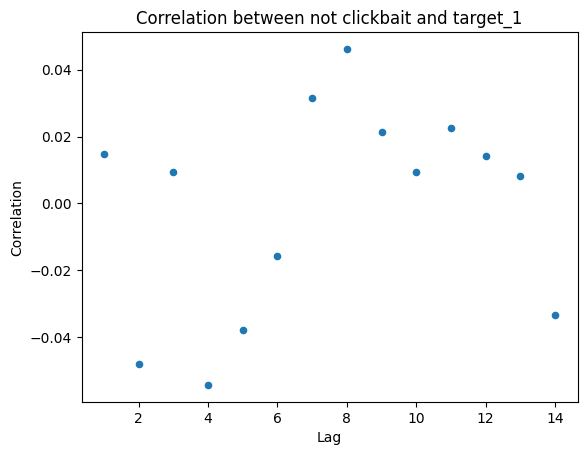

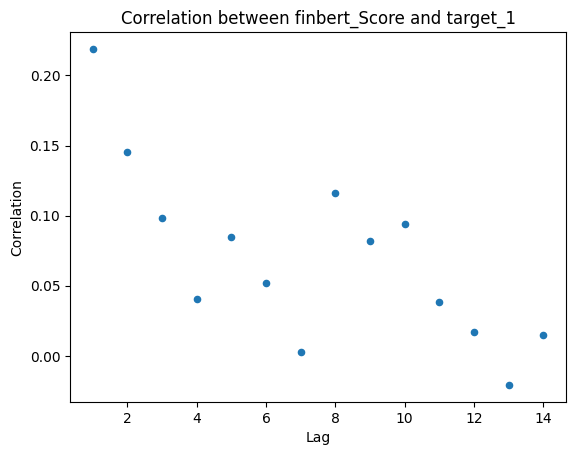

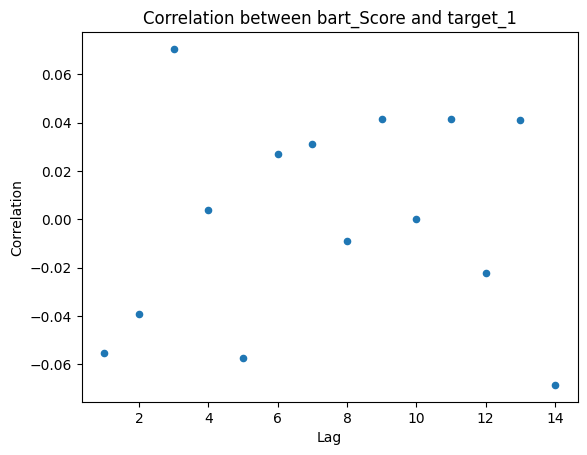

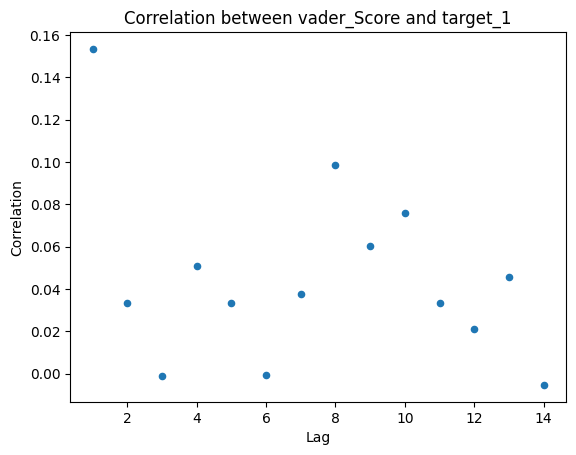

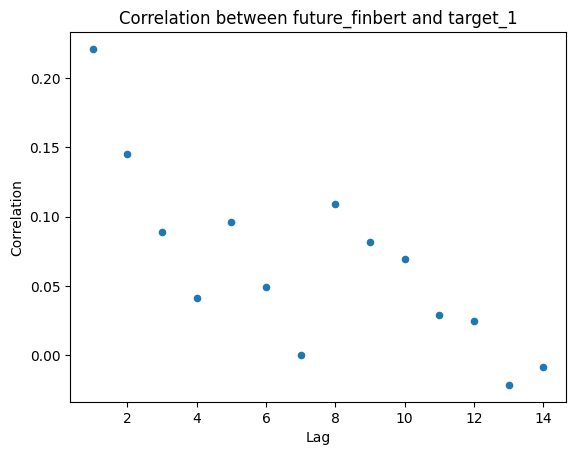

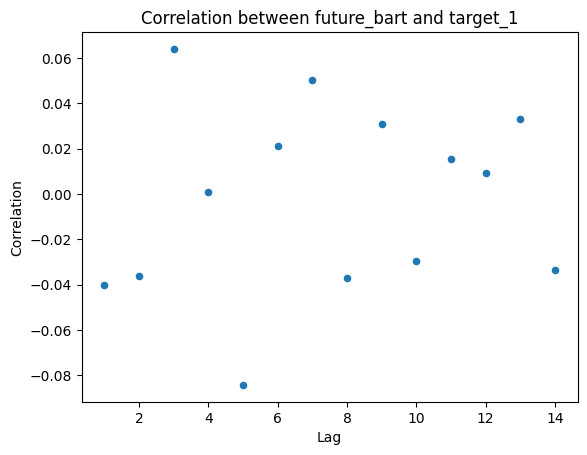

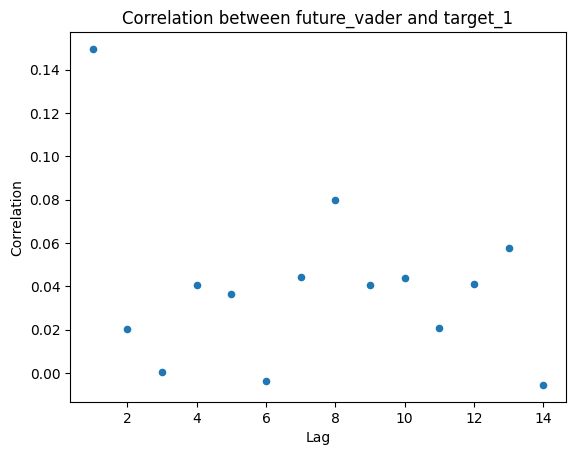

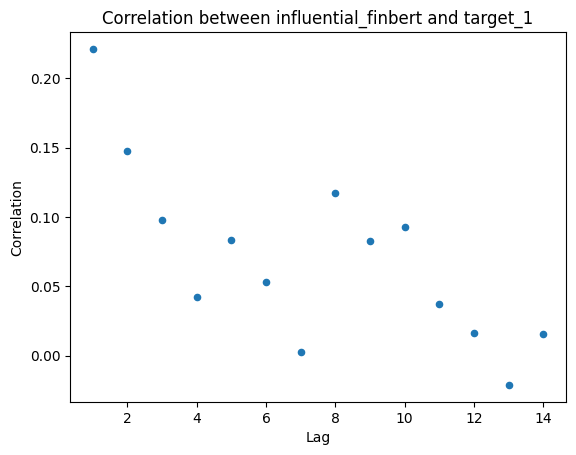

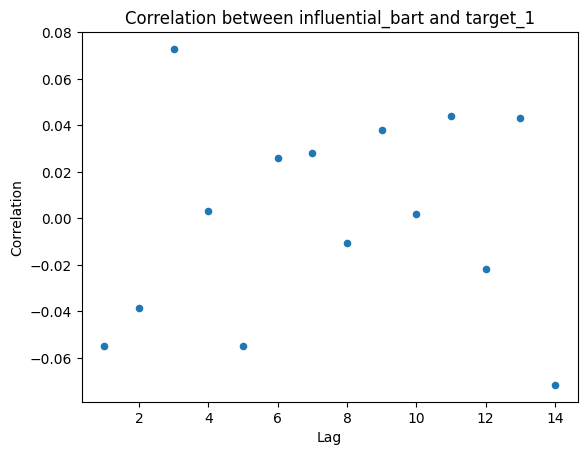

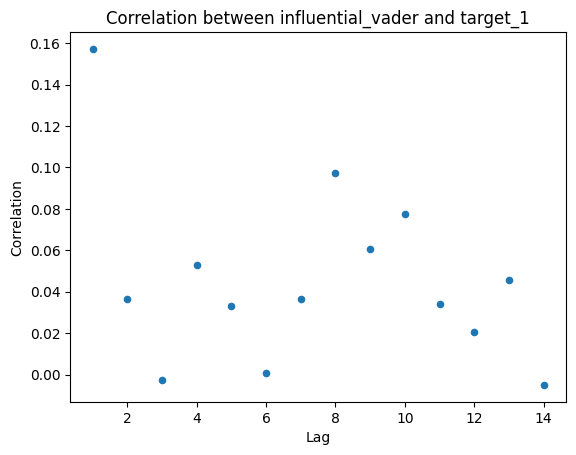

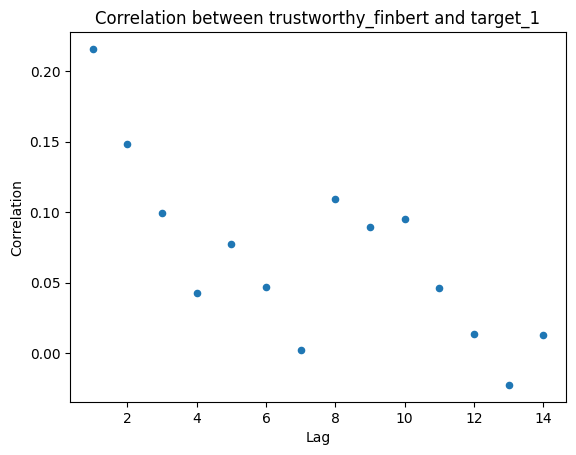

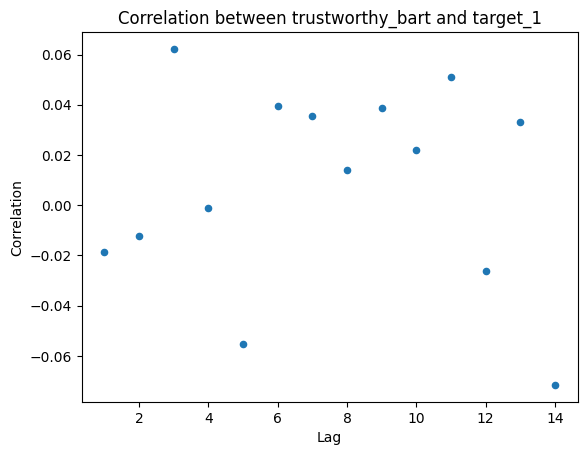

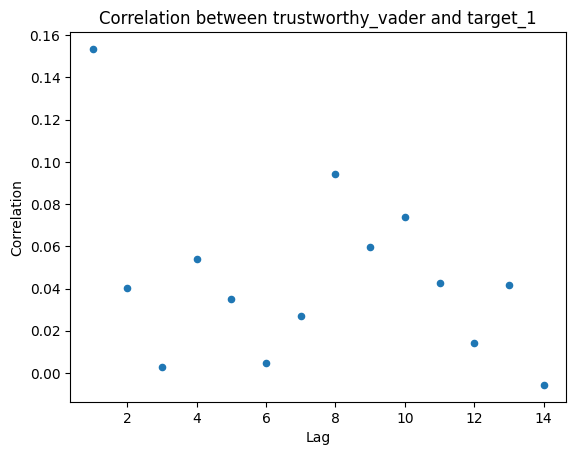

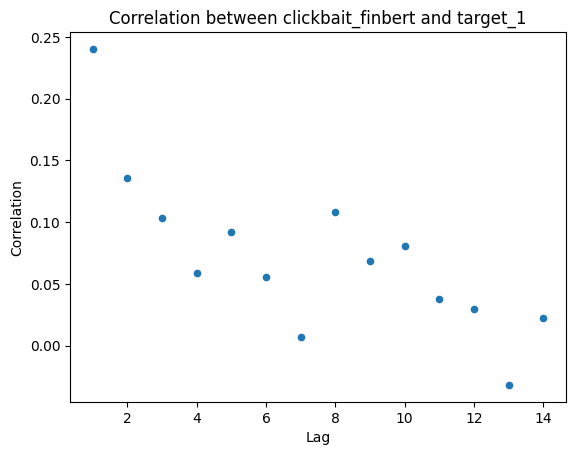

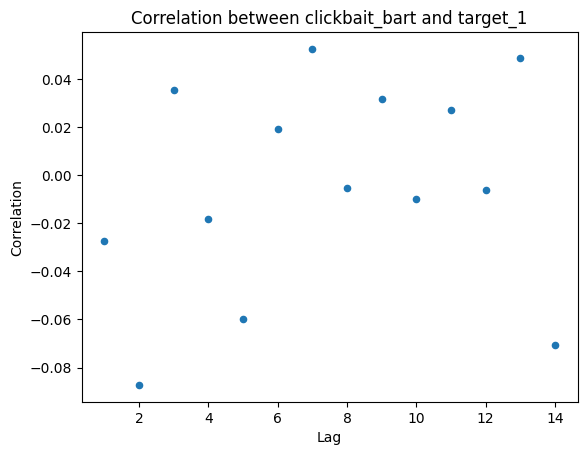

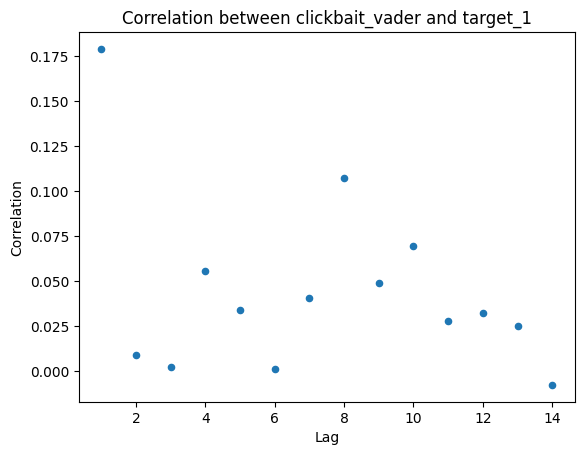

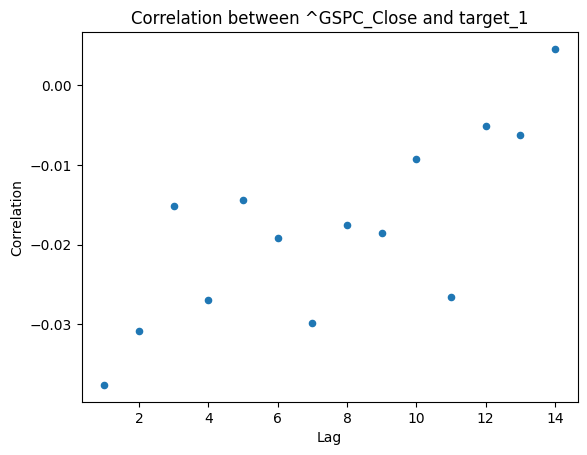

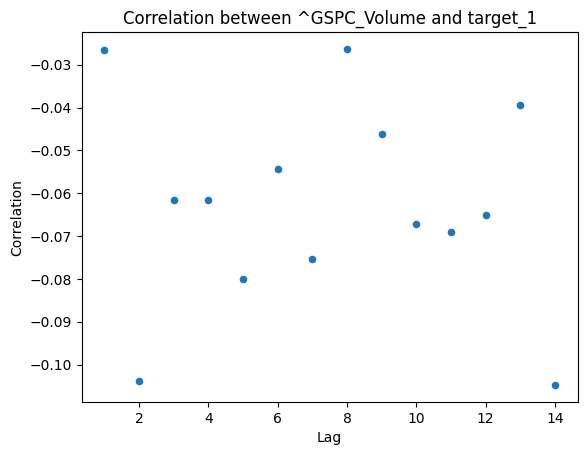

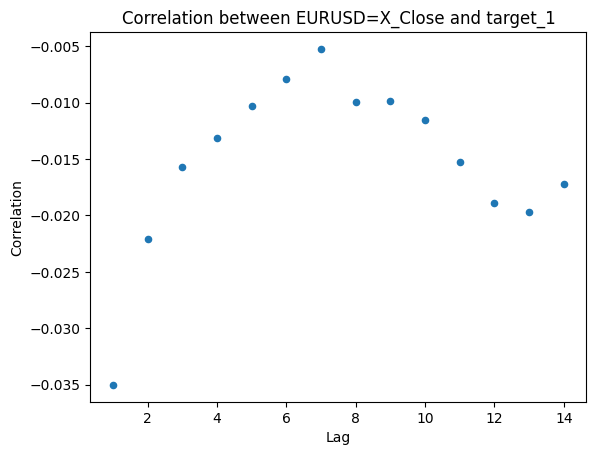

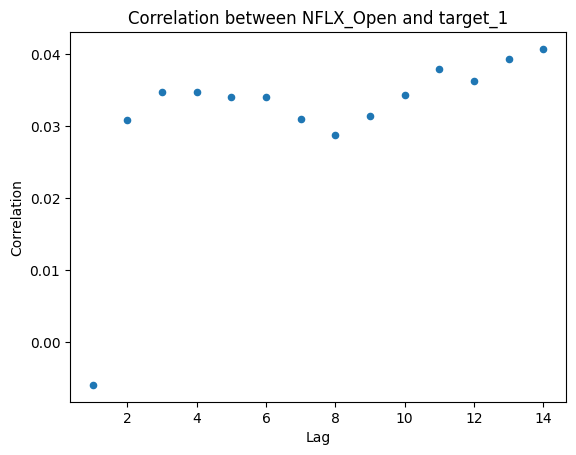

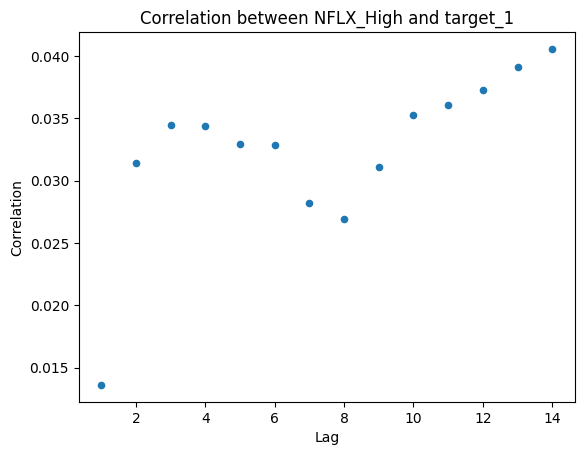

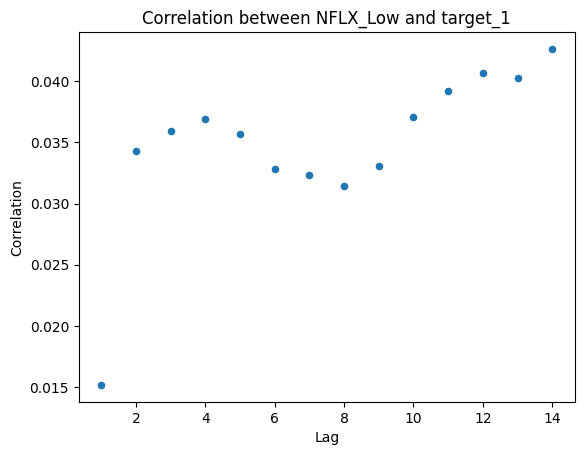

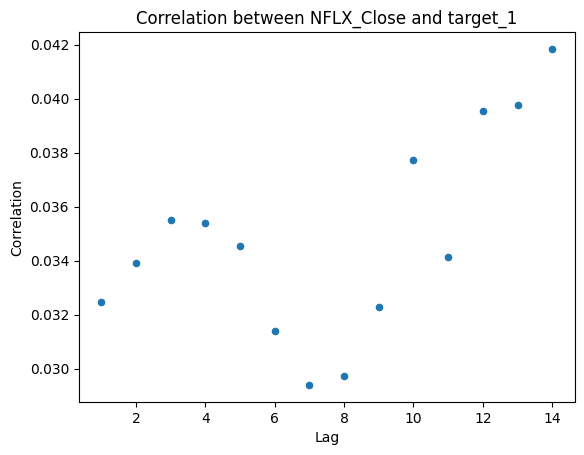

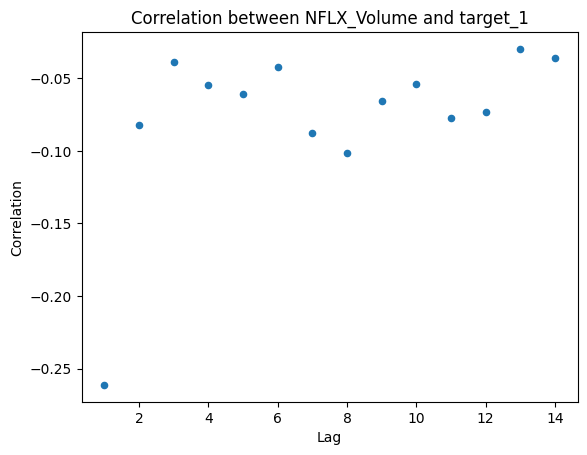

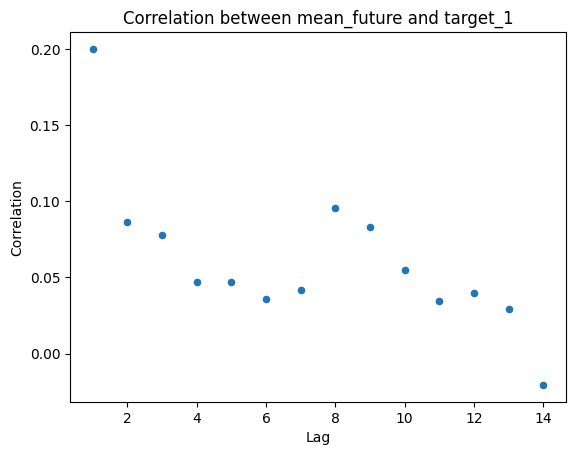

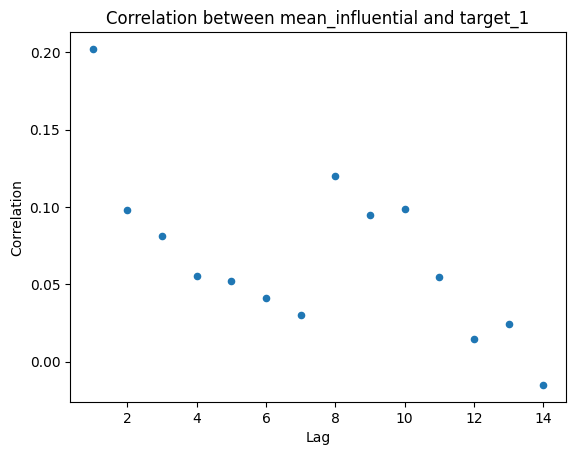

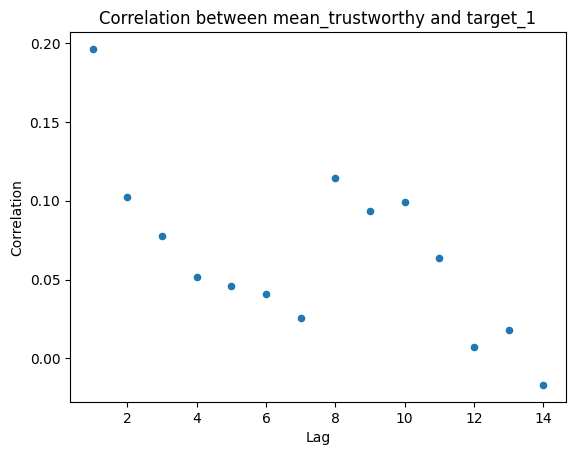

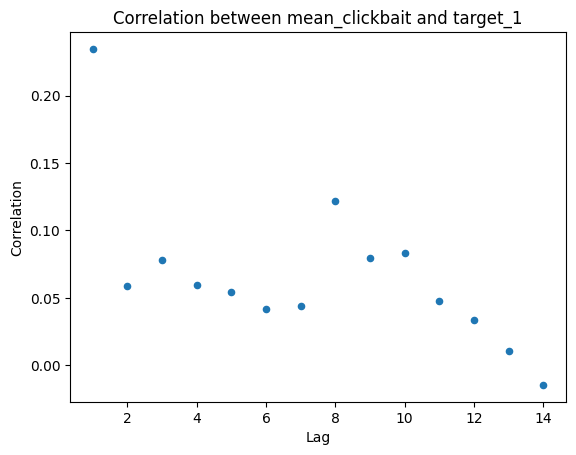

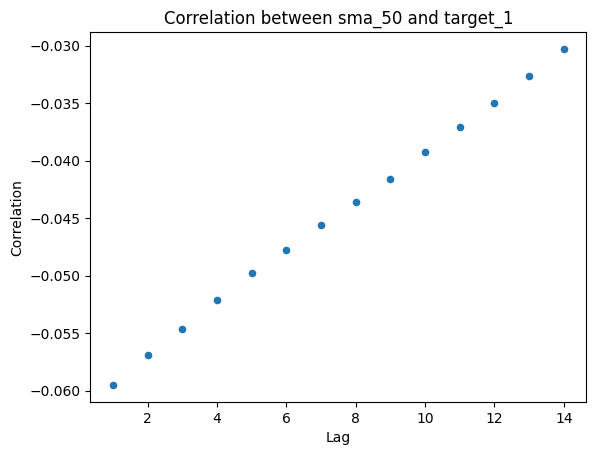

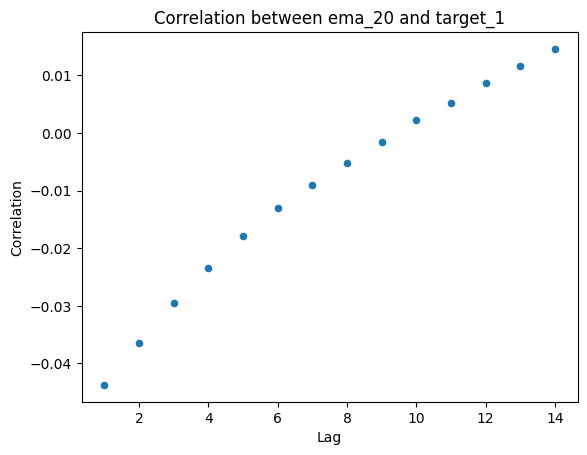

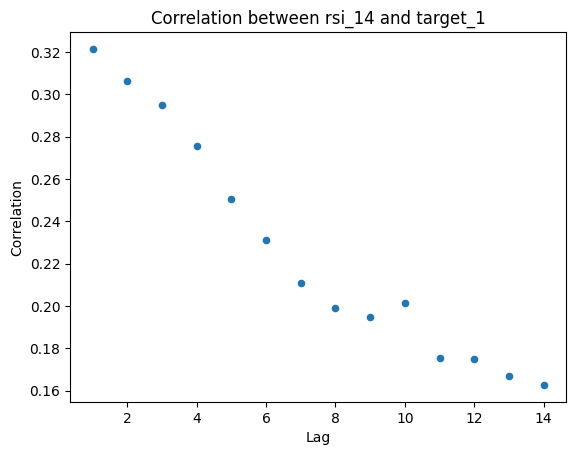

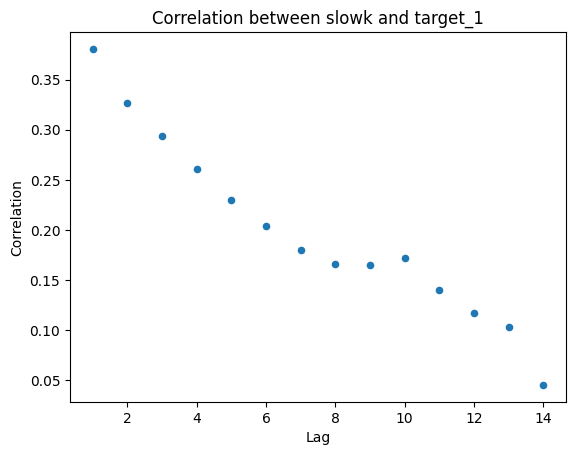

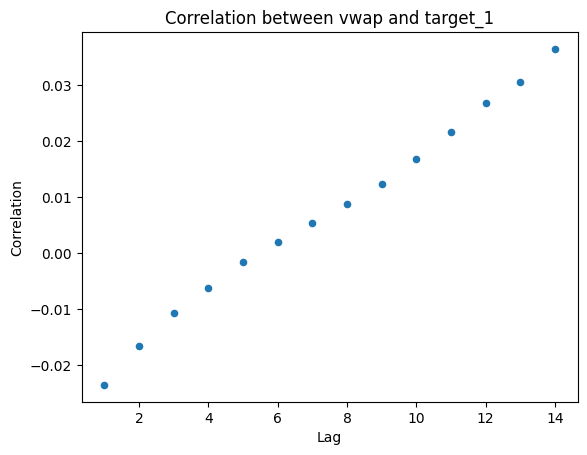

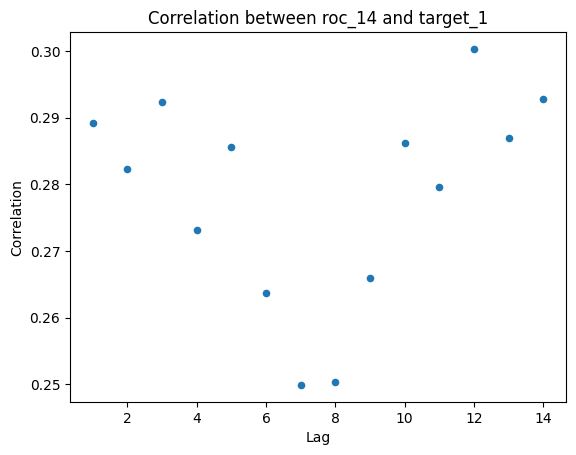

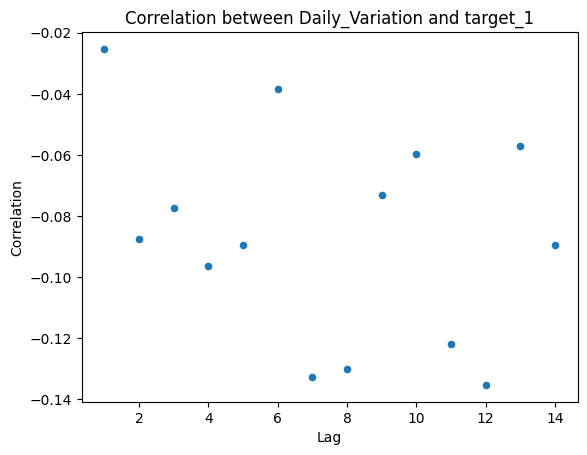

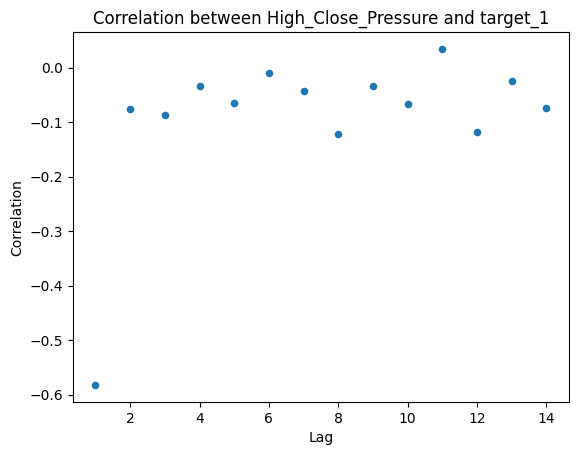

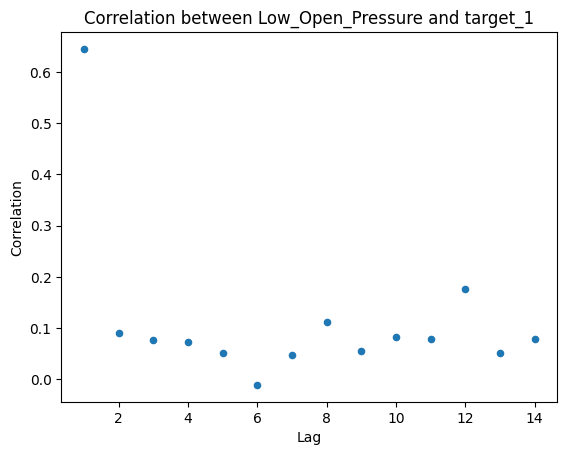

In [63]:
def plot_lagged_correlations(df, target):
    # Calculate correlations for all columns and target
    correlations = {}
    for col in df.columns:
        if col != target:
            correlations[col] = calculate_lagged_correlation(col, target, df)

    # Plot correlations for each column
    for col, corr in correlations.items():
        corr.plot(x='Lag', y='Correlation', kind='scatter')
        plt.title(f'Correlation between {col} and {target}')
        plt.show()

plot_lagged_correlations(train_set.drop(columns=['Date','target_5','target_10','target_20']), 'target_1')

In [23]:
import matplotlib.pyplot as plt

def check_and_plot_correlation(df, target_col,method_='spearman'):
    # Calculate the correlation matrix
    corr_matrix = df.corr(method= method_)

    # Get the correlation values for the target column
    target_corr = corr_matrix[target_col]

    # Remove the correlation value of the target column with itself
    target_corr = target_corr.drop(target_col)

    # Sort the correlation values in descending order
    target_corr = target_corr.sort_values(ascending=False)

    # Plot the correlation values
    plt.figure(figsize=(10, 6))
    target_corr.plot(kind='bar')
    plt.title(f'Correlation with {target_col}')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.show()

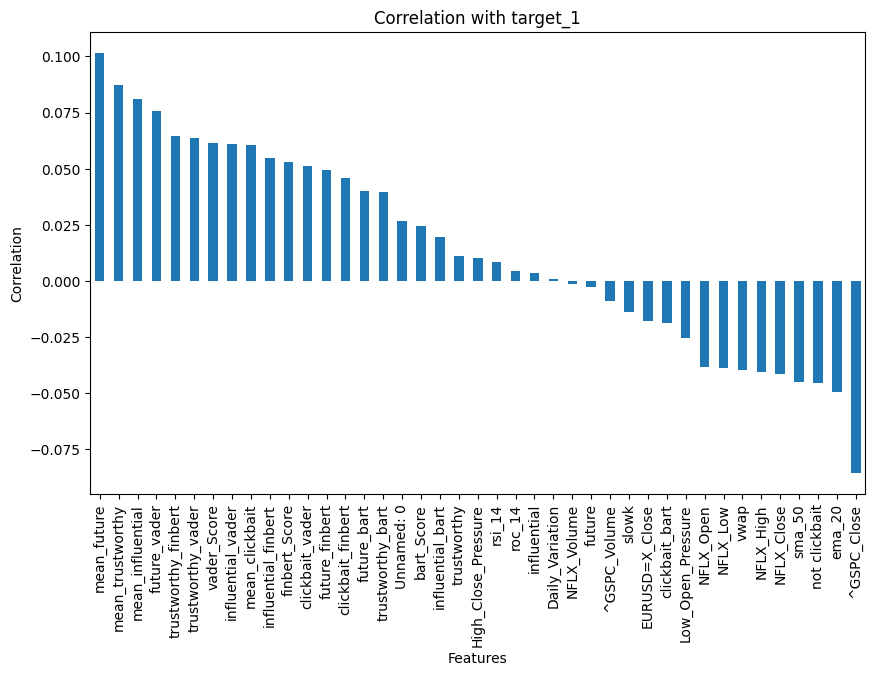

In [38]:
check_and_plot_correlation(train_set.drop(columns=['Date','target_5','target_10','target_20']), 'target_1',method_='spearman')

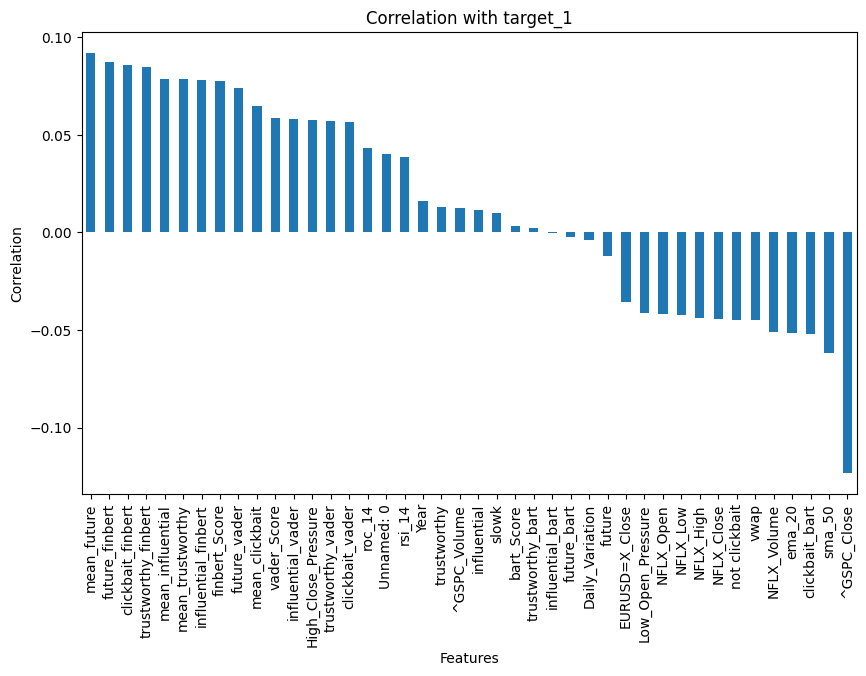

In [25]:
check_and_plot_correlation(train_set.drop(columns=['Date','target_5','target_10','target_20']), 'target_1',method_='pearson')